In [59]:
#common imports
import numpy as np
import matplotlib.pyplot as plt
from random import choice

#keras imports
from tensorflow.keras.models import save_model
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from keras.regularizers import l1, l2,l1_l2
from keras.backend import clear_session
from os import path, getcwd
from keras.utils import image_dataset_from_directory
import pandas as pd

#Hyperparameters
OPTIMIZER = 'adam'
LOSS_FUNCTION = 'binary_crossentropy'
METRICS = ['accuracy', 'f1_score']
EPOCHS = 20
BATCH_SIZE = 50
VERBOSE = 2
REGULARIZER=None
NUMBER_OF_CLASSES = 2

#variables
drive_dir_colab = '/content/drive/MyDrive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/augmented_binary_dataset'

drive_dir_mac = '/Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/augmented_binary_dataset'

jupyter_dir = getcwd()

DATASET_DIRECTORY = drive_dir_mac
#to run locally on mac see : https://github.com/tensorflow/tensorflow/issues/33285
#'/Users/chris/PycharmProjects/Tensorflow/.venv/lib/python3.11/site-packages/tensorflow/python/keras/utils/data_utils.py'

In [60]:
def load_images(dataset_name):
    
    labels_file_path = path.join(DATASET_DIRECTORY + '/' + dataset_name + '/labels/labels.csv')
    file = open(labels_file_path, 'r')
    contents = (file.read())
    the_labels= list(map(int, contents.split(',')))

    return image_dataset_from_directory(
    directory=path.join(DATASET_DIRECTORY, dataset_name),
    labels=the_labels,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=None,
    image_size=(256, 256),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False
)

In [61]:
train_ds= load_images('train')
test_ds = load_images('test')
valid_ds = load_images('valid')

Found 32679 files belonging to 2 classes.
Found 1521 files belonging to 2 classes.
Found 3132 files belonging to 2 classes.


In [72]:
def preprocess_data(a_dataset):
    data = list(a_dataset.as_numpy_iterator())
    X = []
    y = []
    for image, label in data:
        X.append(image)
        y.append(label[0])
    X = np.array(X).astype('float32')
    X = np.array(X)/255
    y = np.array(y).astype(int)
    return (X,y) 

In [73]:
X_train, y_train = preprocess_data(train_ds)
X_test, y_test = preprocess_data(test_ds)
X_valid, y_valid = preprocess_data(valid_ds)

In [77]:
#check that the data has loaded and is of the expected shape
assert X_train.shape == (train_ds.cardinality(),256,256,1)
assert y_train.shape == (train_ds.cardinality())
assert X_test.shape == (test_ds.cardinality(),256,256,1)
assert y_test.shape == (test_ds.cardinality())
assert X_valid.shape == (valid_ds.cardinality(),256,256,1)
assert y_valid.shape == (valid_ds.cardinality())

In [78]:
print ('Sample training label:\n'   + str(choice(y_train)))

Sample training label:
1


In [87]:
#ensure labels are in the right order!
augmented_labels = []

for each in range(10):
    augmented_labels.append(y_train[(each *9)])
    
print(augmented_labels)

[0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


Sample training image:
[[[0.60784316]
  [0.5647059 ]
  [0.5411765 ]
  ...
  [0.01176471]
  [0.01176471]
  [0.01176471]]

 [[0.6117647 ]
  [0.5568628 ]
  [0.5294118 ]
  ...
  [0.01176471]
  [0.01176471]
  [0.01176471]]

 [[0.60784316]
  [0.54901963]
  [0.5254902 ]
  ...
  [0.01176471]
  [0.01176471]
  [0.01176471]]

 [[0.6039216 ]
  [0.54901963]
  [0.5254902 ]
  ...
  [0.01176471]
  [0.01176471]
  [0.01176471]]

 [[0.6117647 ]
  [0.5529412 ]
  [0.5254902 ]
  ...
  [0.01176471]
  [0.01176471]
  [0.01176471]]]


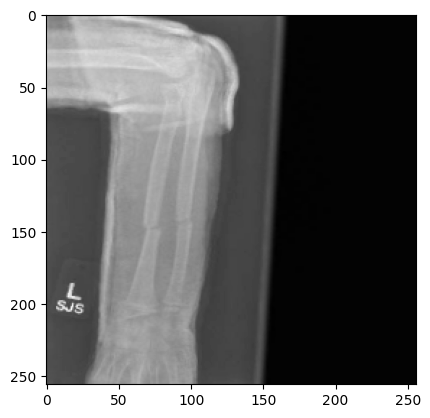

In [46]:
random_training_image = choice(X_train)
print ('Sample training image:\n'   + str(random_training_image[:5]))
plt.imshow(random_training_image, cmap='gray')
plt.show()

In [52]:
def create_model():
#create a Sequential  model
    model = models.Sequential()
    input_shape = (256,256,1)

#Add the layers
#Add 2 convolutional layers paired with max pooling layers
    model.add(Input(input_shape))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
   
#Flatten the output so that it can be processed as a Vector by the subsequnet Dense layer
    model.add(Flatten())

#add a fully connected layer with  64 neurons and a relu activation function ouput shape = 64
    model.add(Dense(64, kernel_regularizer=REGULARIZER, activation='relu'))

#Add a fully connected output layer with 10 neurons - 1 for each class in the dataset and a softmax activation function
#(I specifically chose softmax because this activation function is appropriate for multi-classification problems)

    model.add(Dense(1, activation='sigmoid'))

#compile and fit the model, initially using the default optimizer RMSprop

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=METRICS)

    return model

In [53]:
model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    31,490,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,564,673 (120.41 MB)

 Trainable params: 31,564,673 (120.41 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model = create_model()
model_history = model.fit(X_train,
                          y_train,
                          epochs = EPOCHS,
                          verbose = VERBOSE,
                          validation_data=(X_valid, y_valid))

Epoch 1/20


2024-03-09 10:54:24.132528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1022/1022 - 937s - 917ms/step - accuracy: 0.5014 - f1_score: 0.6638 - loss: 0.6932 - val_accuracy: 0.5029 - val_f1_score: 0.6641 - val_loss: 0.6935
Epoch 2/20
1022/1022 - 301s - 294ms/step - accuracy: 0.5008 - f1_score: 0.6638 - loss: 0.6932 - val_accuracy: 0.5029 - val_f1_score: 0.6641 - val_loss: 0.6934
Epoch 3/20
1022/1022 - 255s - 249ms/step - accuracy: 0.5014 - f1_score: 0.6638 - loss: 0.6931 - val_accuracy: 0.5029 - val_f1_score: 0.6641 - val_loss: 0.6934
Epoch 4/20
1022/1022 - 253s - 248ms/step - accuracy: 0.5018 - f1_score: 0.6638 - loss: 0.6932 - val_accuracy: 0.5019 - val_f1_score: 0.6641 - val_loss: 0.6934
Epoch 5/20
1022/1022 - 259s - 253ms/step - accuracy: 0.5023 - f1_score: 0.6638 - loss: 0.6932 - val_accuracy: 0.5016 - val_f1_score: 0.6641 - val_loss: 0.6934
Epoch 6/20
1022/1022 - 261s - 255ms/step - accuracy: 0.5025 - f1_score: 0.6638 - loss: 0.6932 - val_accuracy: 0.4997 - val_f1_score: 0.6641 - val_loss: 0.6933
Epoch 7/20
1022/1022 - 261s - 256ms/step - accuracy: 0.50

In [55]:
evaluation = model.evaluate(
    x=X_test,
    y=y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5286 - f1_score: 0.6409 - loss: 0.6924


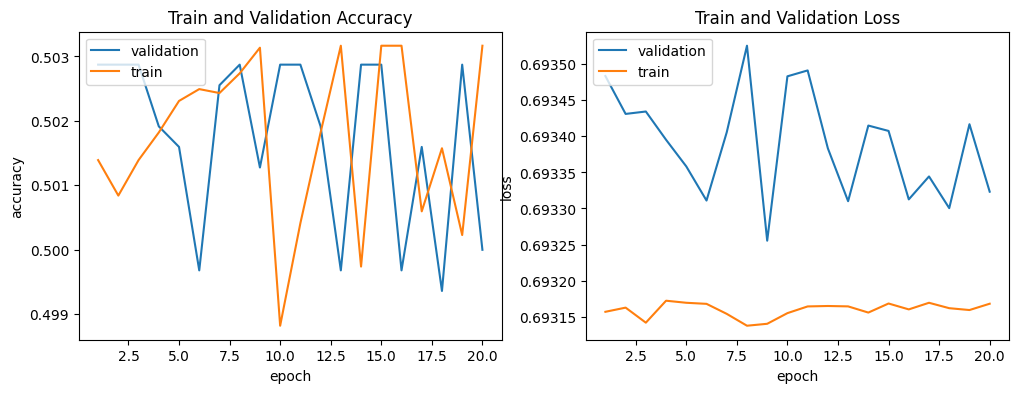

In [56]:
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, EPOCHS+1), valid_accuracy) 
accuracy.plot(range(1, EPOCHS+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, EPOCHS+1), valid_loss)
loss.plot(range(1, EPOCHS+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()